# Problem Statement

I have written my own data retrieval python program that retrieves data from Land Transport Authority (LTA) DataMall Bus Arrival API (https://datamall.lta.gov.sg/). The program collects data from the API every minute for a specific bus route and appends the results into a CSV file.

Given this dataset, can we capture the seasonality and patterns that is present and predict the travel duration between two stops accurately using Machine Learning (ML) algorithms?

In [66]:
import pandas as pd

csv_file_path = '../data-retriever/data/903.csv'

#NEW API SCHEMA 2021
#Origin, Destination, ETA, Lat, Long, Visit Number, Load, Feature, Type, Current Stop, Next Stop, Service, Current Time
new_col =  ['origin', 'dest', 'eta', 'lat', 'long', 'visit_num', 'load', 'feature', 'type', 'current_stop', \
            'next_stop', 'service', 'current_time', 'eta2']

df = pd.read_csv(csv_file_path, index_col=False, names = new_col)


# Let's take a brief look at our dataset! 

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   origin        352 non-null    int64  
 1   dest          352 non-null    int64  
 2   eta           352 non-null    object 
 3   lat           352 non-null    float64
 4   long          352 non-null    float64
 5   visit_num     352 non-null    int64  
 6   load          352 non-null    object 
 7   feature       352 non-null    object 
 8   type          352 non-null    object 
 9   current_stop  352 non-null    int64  
 10  next_stop     336 non-null    float64
 11  service       352 non-null    int64  
 12  current_time  352 non-null    object 
 13  eta2          352 non-null    object 
dtypes: float64(3), int64(5), object(6)
memory usage: 38.6+ KB


# Handling NaN values in our dataset
Oh? We have some NaN values in our next_stop column, let's dig deep to find out why!

In [68]:
df.loc[df['next_stop'].isnull()]

,origin,dest,eta,lat,long,visit_num,load,feature,type,current_stop,next_stop,service,current_time,eta2
21,46009,46009,2021-10-16T16:42:00+08:00,0.0,0.0,1,SEA,WAB,SD,46009,NaN,903,2021-10-16 16:39:48.608327+08:00,2021-10-16T16:48:00+08:00
43,46009,46009,2021-10-16T16:42:00+08:00,0.0,0.0,1,SEA,WAB,SD,46009,NaN,903,2021-10-16 16:40:49.814674+08:00,2021-10-16T16:48:00+08:00
65,46009,46009,2021-10-16T16:42:00+08:00,0.0,0.0,1,SEA,WAB,SD,46009,NaN,903,2021-10-16 16:41:32.792664+08:00,2021-10-16T16:48:00+08:00
87,46009,46009,2021-10-16T16:42:00+08:00,0.0,0.0,1,SEA,WAB,SD,46009,NaN,903,2021-10-16 16:42:33.966377+08:00,2021-10-16T16:48:00+08:00
109,46009,46009,2021-10-16T16:42:00+08:00,0.0,0.0,1,SEA,WAB,SD,46009,NaN,903,2021-10-16 16:43:35.050476+08:00,2021-10-16T16:48:00+08:00
131,46009,46009,2021-10-16T16:48:00+08:00,0.0,0.0,1,SEA,WAB,DD,46009,NaN,903,2021-10-16 16:44:36.045882+08:00,2021-10-16T16:54:00+08:00
153,46009,46009,2021-10-16T16:48:00+08:00,0.0,0.0,1,SEA,WAB,DD,46009,NaN,903,2021-10-16 16:45:37.187430+08:00,2021-10-16T16:54:00+08:00
175,46009,46009,2021-10-16T16:48:00+08:00,0.0,0.0,1,SEA,WAB,DD,46009,NaN,903,2021-10-16 16:46:38.641953+08:00,2021-10-16T16:54:00+08:00
197,46009,46009,2021-10-16T16:48:00+08:00,0.0,0.0,1,SEA,WAB,DD,46009,NaN,903,2021-10-16 16:47:39.732898+08:00,2021-10-16T16:54:00+08:00
219,46009,46009,2021-10-16T16:48:00+08:00,0.0,0.0,1,SEA,WAB,DD,46009,NaN,903,2021-10-16 16:48:40.785729+08:00,2021-10-16T16:54:00+08:00


After investigating further by taking a look at our route file, it turns out that this bus service is a loop service (starting and ending on the same stop). Hence, the API does not distinguish between the arrival time at the starting and ending stop, returning only the ETA of the starting stop. 

In short, it is safe to drop these rows!

In [69]:
df = df.dropna()
df.reset_index(drop=True, inplace=True)

# Let's do some calculations and create new columns!

In [70]:
#Convert to eta column into a datetime field
df['eta'] = pd.to_datetime(df['eta'])
df['eta2'] = pd.to_datetime(df['eta2'])
df['current_time'] = pd.to_datetime(df['current_time'])

#Convert numerical data columns to Integer
df['current_stop'] = df['current_stop'].astype(int)
df['next_stop'] = df['next_stop'].astype(int)

df.head()

,origin,dest,eta,lat,long,visit_num,load,feature,type,current_stop,next_stop,service,current_time,eta2
0,46009,46009,2021-10-16 16:42:00+08:00,0.000000,0.000000,1,SEA,WAB,SD,46009,46271,903,2021-10-16 16:39:47.686862+08:00,2021-10-16 16:48:00+08:00
1,46009,46009,2021-10-16 16:39:51+08:00,1.437194,103.787124,1,SEA,WAB,DD,46271,46301,903,2021-10-16 16:39:47.749743+08:00,2021-10-16 16:43:09+08:00
2,46009,46009,2021-10-16 16:41:22+08:00,1.437194,103.787124,1,SEA,WAB,DD,46301,46311,903,2021-10-16 16:39:47.789556+08:00,2021-10-16 16:44:27+08:00
3,46009,46009,2021-10-16 16:42:29+08:00,1.437194,103.787124,1,SEA,WAB,DD,46311,46249,903,2021-10-16 16:39:47.839933+08:00,2021-10-16 16:45:20+08:00
4,46009,46009,2021-10-16 16:43:28+08:00,1.437194,103.787124,1,SEA,WAB,DD,46249,46179,903,2021-10-16 16:39:47.876684+08:00,2021-10-16 16:46:23+08:00


# Calculating travel duration between two stops

Since we have the estimated time of arrival (ETA) for two bus instances that was retrieved from the API, we can calculate the travel duration that it takes for the bus to travel from the previous stop to the current stop.

In [71]:
#Calculate duration column and get results in seconds
df['duration'] = df['eta2'] - df['eta']
df['duration_seconds'] = df['duration'].dt.total_seconds()

df.head()

,origin,dest,eta,lat,long,visit_num,load,feature,type,current_stop,next_stop,service,current_time,eta2,duration,duration_seconds
0,46009,46009,2021-10-16 16:42:00+08:00,0.000000,0.000000,1,SEA,WAB,SD,46009,46271,903,2021-10-16 16:39:47.686862+08:00,2021-10-16 16:48:00+08:00,0 days 00:06:00,360.0
1,46009,46009,2021-10-16 16:39:51+08:00,1.437194,103.787124,1,SEA,WAB,DD,46271,46301,903,2021-10-16 16:39:47.749743+08:00,2021-10-16 16:43:09+08:00,0 days 00:03:18,198.0
2,46009,46009,2021-10-16 16:41:22+08:00,1.437194,103.787124,1,SEA,WAB,DD,46301,46311,903,2021-10-16 16:39:47.789556+08:00,2021-10-16 16:44:27+08:00,0 days 00:03:05,185.0
3,46009,46009,2021-10-16 16:42:29+08:00,1.437194,103.787124,1,SEA,WAB,DD,46311,46249,903,2021-10-16 16:39:47.839933+08:00,2021-10-16 16:45:20+08:00,0 days 00:02:51,171.0
4,46009,46009,2021-10-16 16:43:28+08:00,1.437194,103.787124,1,SEA,WAB,DD,46249,46179,903,2021-10-16 16:39:47.876684+08:00,2021-10-16 16:46:23+08:00,0 days 00:02:55,175.0


In [72]:
df.loc[df['duration_seconds'] < 0]

,origin,dest,eta,lat,long,visit_num,load,feature,type,current_stop,next_stop,service,current_time,eta2,duration,duration_seconds


# Why is this happening?

In [73]:
df = df.loc[df['duration_seconds'] > 0]
df.reset_index(drop=True, inplace=True)

df.head()

,origin,dest,eta,lat,long,visit_num,load,feature,type,current_stop,next_stop,service,current_time,eta2,duration,duration_seconds
0,46009,46009,2021-10-16 16:42:00+08:00,0.000000,0.000000,1,SEA,WAB,SD,46009,46271,903,2021-10-16 16:39:47.686862+08:00,2021-10-16 16:48:00+08:00,0 days 00:06:00,360.0
1,46009,46009,2021-10-16 16:39:51+08:00,1.437194,103.787124,1,SEA,WAB,DD,46271,46301,903,2021-10-16 16:39:47.749743+08:00,2021-10-16 16:43:09+08:00,0 days 00:03:18,198.0
2,46009,46009,2021-10-16 16:41:22+08:00,1.437194,103.787124,1,SEA,WAB,DD,46301,46311,903,2021-10-16 16:39:47.789556+08:00,2021-10-16 16:44:27+08:00,0 days 00:03:05,185.0
3,46009,46009,2021-10-16 16:42:29+08:00,1.437194,103.787124,1,SEA,WAB,DD,46311,46249,903,2021-10-16 16:39:47.839933+08:00,2021-10-16 16:45:20+08:00,0 days 00:02:51,171.0
4,46009,46009,2021-10-16 16:43:28+08:00,1.437194,103.787124,1,SEA,WAB,DD,46249,46179,903,2021-10-16 16:39:47.876684+08:00,2021-10-16 16:46:23+08:00,0 days 00:02:55,175.0


In [74]:
bus_stops = df['current_stop'].unique()
bus_stops

array([46009, 46271, 46301, 46311, 46249, 46179, 46169, 46159, 46149,
       46119, 46069, 46088, 46111, 46141, 46151, 46161, 46171, 46241,
       46319, 46309, 46279])

<AxesSubplot:xlabel='current_time', ylabel='duration_seconds'>

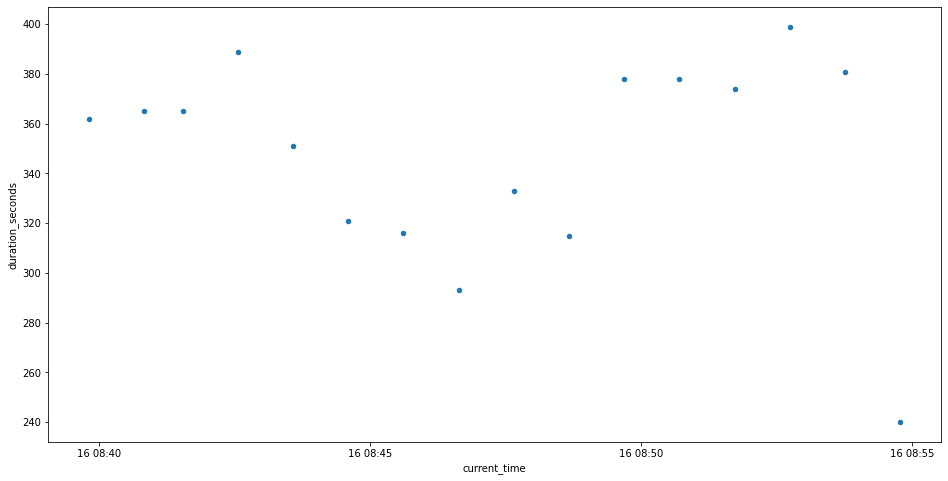

In [76]:
first_stop = df.loc[df['current_stop'] == 46151]

first_stop.plot.scatter(x='current_time', y='duration_seconds',figsize=(16,8))

# Summary

## Findings
1. Time of the day shows a non-linear correlation to the travel duration between two stops
